In [ ]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport

In [ ]:
# Note: this is dangerous since we don't know what we import, but it's a lazy 
# and definitely the most compact way to get all constants:
from parameters import *
# Just make sure to put only global constants in that file, which are not going to be
# confused with parameters that are susceptible to change, such as resolution

In [ ]:
# load the velocity field:
datap = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
u,v = np.load(datap)

"""
fig, ax = plt.subplots(figsize=(4,4))
ax.quiver(u.T, v.T)
ax.set_title('velocity field')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
""";

**species and temperature**

Define the different species

In [ ]:
%autoreload 1
from species_transport import set_CH4_BC, set_O2_BC, set_N2_BC, set_CO2_BC, set_H2O_BC, set_Temp_BC

Nt = 10000

CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,M))

# note, if we take the following initial values (air inside the chamber at t0),
# the diffusive zone question (3.2) does not make much sense;
O2[:] = .233
N2[:] = .767
T[:] = 300
BCs = [set_CH4_BC, set_O2_BC, set_N2_BC, set_H2O_BC, set_CO2_BC]

Y = np.array([CH4, O2, N2, CO2, H2O])
Y_t = np.zeros((*Y.shape, Nt))
T_t = np.zeros((*T.shape, Nt))

In [5]:
from Funcs import advance_adv_diff_RK4

dt=1e-6

def evolve_species(Y, T, BCs, kspec='all', eps=1e-10):
    
    nspec = Y.shape[0]
    
    if kspec=='all':
        kspec = np.arange(nspec)
    
    for n in range(Nt):
        for k in kspec:
            # apply BCs
            Y[k] = BCs[k](Y[k])
            
            if k in kspec[:-1]:
                Y[k] = advance_adv_diff_RK4(Y[k], dt, u, v, dx, dy, nu)
                
            else:
                # normalization condition:
                Y[k] = 1 + Y[k] - np.sum(Y, axis=0)
            Y[k] = BCs[k](Y[k])
            
        # (almost) same procedure for temperature:
        #T = advance_adv_diff(T, dt, u, v, dx, dy, nu)
        T = set_Temp_BC(T)
        
        # remove numerical error
        Y[Y<= eps] = 0.0
        
        Y_t[:,:,:,n] = Y
        T_t[:,:,n]   = T
        
        """
        #normalizing
        sum_Y = np.sum(Y[:-1],axis=0) 
        for k in range(Y.shape[0]-1):
            Y[k]=Y[k]/sum_Y
        """
    
    return Y, T

In [6]:
Y, T = evolve_species(Y, T, BCs, kspec='all')

In [9]:
"""
from pathlib import Path
datap = Path('data/species') / 'N{}M{}.npy'.format(N,M)
species_data = np.zeros((Y.shape[0] + 1, *Y.shape[1:]))
species_data[:-1,:, :] = Y
species_data[-1, :, :] = T
np.save(datap, species_data)
"""

In [10]:
species_data = np.load(datap)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
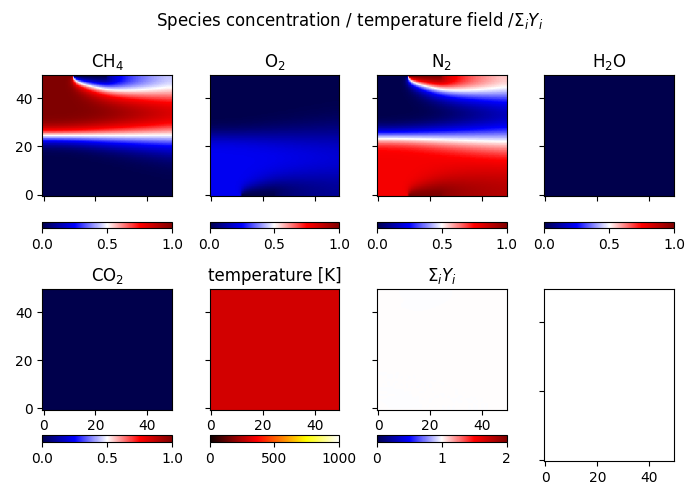

In [12]:
from visualization import plot_species_overview
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
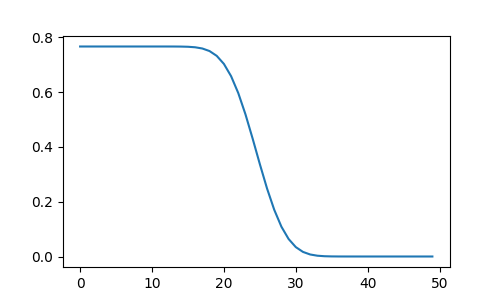

In [13]:
left_wall_N2 = Y_t[2,0,:,-1]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(left_wall_N2)

### Combustion

In the following, a little test is done to check whether the intergation of the $Y_k$ and $T$ differential equations is done correctly. The initial conditions given hereafter should leed (if time step is chosen appropriately) to a rise from $1000$K to $\sim 3500$K.

In [54]:
%autoreload 1
from species_transport import Y_to_n, get_Q, W, nu_stoch, dh0

@jit(nopython=True)
def advance_chem(Y,T,dt_chem):
    n = Y_to_n(Y)
    Q = get_Q(n[0], n[1], T)
    nspec = Y.shape[0]
    omega_dot = np.zeros(nspec)
    for k in range(nspec):
        omega_dot[k] = W[k] * nu_stoch[k] * Q
        Y[k] += dt_chem * omega_dot[k] / rho

    omegaT_dot = - np.sum(dh0 / W * omega_dot)
    T += dt_chem * omegaT_dot / rho / cp
    return Y,T

@jit(nopython=True)
def integr_chem_0d(Y, T, dt, Nt_chem):
    """
    Integration of the chemistry equations for the homogeneous reactor.
    Args:
        - Y:  mass fraction of species k
        - T:  Temperature in K
        - dt: integrates the chemical equation from t to t+dt
        - Nt_chem: number of time steps for the integration (dt_chem = dt/Nt_chem)
    """
    dt_chem = dt / Nt_chem        
    
    T_t = np.zeros(Nt_chem)
    for n in range(Nt_chem):        
        T_t[n] = T
        Y,T = advance_chem(Y,T,dt_chem)
    return Y, T_t


3268.112707455815


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
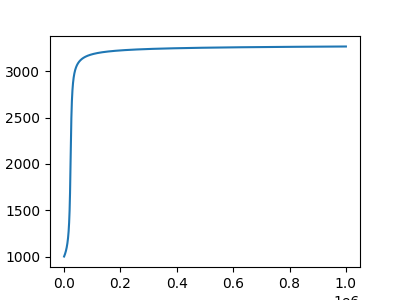

In [55]:
#Yk = np.zeros((N,M))
Y_CH4 = 0.055
Y_O2 = 0.233 * (1 - Y_CH4)
Y_N2 = 1 - Y_O2 - Y_CH4
T = 1000
Y_CO2 = 0
Y_H2O = 0

_Y = np.array([Y_CH4, Y_O2, Y_N2, Y_H2O, Y_CO2])

dt = 1e-5
Nt_chem = int(1e6)

_Y, T_t = integr_chem_0d(_Y, T, dt, Nt_chem)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(T_t)
print(T_t[-1])

We are now going to to transfer the above funtion to the 2D case in order to apply it to each cell of the domain

In [176]:
from Funcs import advance_adv_diff_RK3

@jit(nopython=True)
def integr_chem_2d(Y, T, dt, Nt_chem, evolve_T=True):
    """
    Integration of the chemistry equations for the whole chamber.
    Args:
        - Y:  mass fraction of species k
        - T:  Temperature in K
        - dt: integrates the chemical equation from t to t+dt
        - Nt_chem: number of time steps for the integration (dt_chem = dt/Nt_chem)
    """
    dt_chem = dt / Nt_chem        
    
    for n in range(Nt_chem):        
        n = Y_to_n(Y)
        Q = get_Q(n[0], n[1], T)
        omega_dot = np.zeros_like(Y)
        nspec = Y.shape[0]
        for k in range(nspec):
            #print(W[k], nu_stoch[k], Q.shape)
            omega_dot[k] = W[k] * nu_stoch[k] * Q
            #print(omega_dot.shape)
            Y[k] += dt_chem * omega_dot[k] / rho
        #print(dh0.shape, W.shape, omega_dot.shape)
        
        if evolve_T:
            omegaT_dot = np.zeros_like(T)
            for k in range(nspec):
                omegaT_dot -= dh0[k] / W[k] * omega_dot[k]
            #print(omegaT_dot.shape)
            T += dt_chem * omegaT_dot / rho / cp
                
    return Y, T

def evolve_species_revisited(Y, T, BCs, Nt, kspec='all', eps=1e-10, evolve_T=True):
    
    nspec = Y.shape[0]
    
    if kspec=='all':
        kspec = np.arange(nspec)
    
    for n in range(Nt):
        
        Nt_chem = 100 if evolve_T else 100
        Y, _ = integr_chem_2d(Y, T, dt, Nt_chem, evolve_T)
        if evolve_T:
            T = _
            
            # (almost) same procedure for temperature as for species:
            T = advance_adv_diff_RK4(T, dt, u, v, dx, dy, nu)
            T = set_Temp_BC(T)
            
        for k in kspec:
            # apply BCs
            Y[k] = BCs[k](Y[k])
            
            if k in kspec[:-1]:
                Y[k] = advance_adv_diff_RK4(Y[k], dt, u, v, dx, dy, nu)
                
            else:
                # normalization condition:
                Y[k] = 1 + Y[k] - np.sum(Y, axis=0)
            Y[k] = BCs[k](Y[k])
            
            
        # remove numerical error
        #Y[Y<= eps] = 0.0
    
    return Y, T

Here is the workflow: first, we inititate the transport as done previously:

In [177]:
species_data = np.load(datap)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
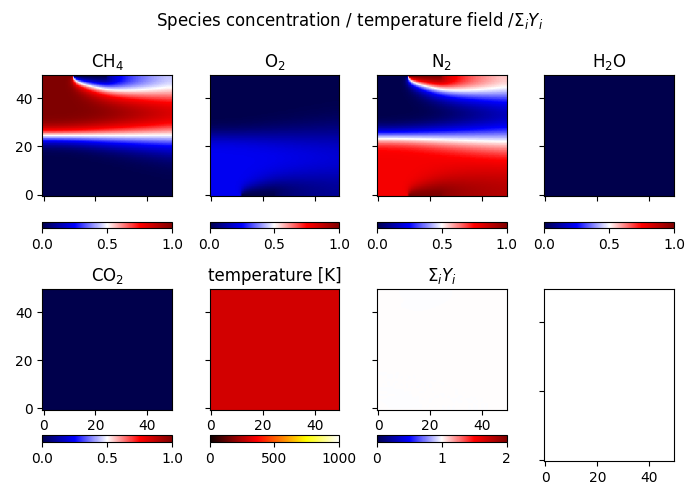

In [178]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Now we impose a temperature of 1000 in the center of the chamber

In [179]:
T = np.ones((N,M)) * 300

Th_thick = 0.05*10**-3
Th_band = np.array([T.shape[1]/2-Th_thick/dy,
                    T.shape[1]/2+Th_thick/dy],dtype=int)

T[:,Th_band[0]:Th_band[1]] = 1000
"""
plt.figure()
plt.imshow(T.T,cmap="seismic")
plt.title("Temperature distribution in first frame")
plt.colorbar()
plt.show()
""";

Evolve chemistry (while keeping $T$ constant)

In [180]:
Nt = 500
Y, _ = evolve_species_revisited(Y,T,BCs,Nt, evolve_T=False);

We check that CO2 and H2O have been indeed been created in the center of the cell.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
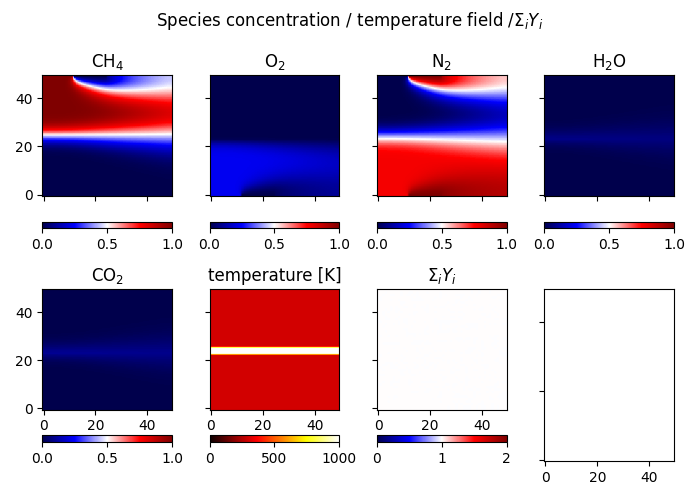

In [181]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Once the ignition has stabilized, add the temperature evolution (does not seem to work yet if we uncomment the lines above).

In [189]:
Nt = 100
Y, T = evolve_species_revisited(Y,T,BCs,Nt, evolve_T=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
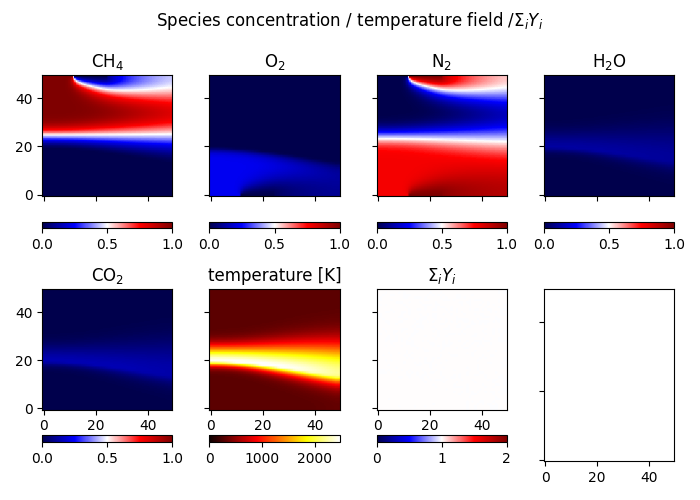

In [190]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)